# Preparation

In [ ]:
import sys
sys.path.append("..")

In [1]:
import os
from dotenv import load_dotenv
from copy import deepcopy
from typing import List
import numpy as np

# +++ ODEA +++
from odea.abstraction.concept import Concept

from odea.abstraction import metrics as m
from odea.abstraction.helper import metrics as m_helper
from odea.abstraction.helper import abstraction as abs_helper

from odea.io.sparql import SparQLConnector
from odea.io import event_log_helper as helper

from odea.viz.charts import bar_chart, scatter_chart

# +++ Plots +++
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

# +++ PM4Py +++
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

Import event log and low-level concepts:

In [2]:
log_file = '../data/Claim_handeling_v2_filtered.xes'
mapping_file = '../data/claim_event_mapping.csv'

event_to_con_mapping = helper.import_mapping(mapping_file)

ll_concepts: List[Concept]
ll_concepts = helper.concepts_from_log(log_file, mapping_file)

Configure SPARQL wrapper to query the local endpoint:

In [3]:
load_dotenv()

SPARQL_ENDPOINT = os.getenv('SPARQL_ENDPOINT')
SPARQL_PREFIX = os.getenv('SPARQL_PREFIX')

connector = SparQLConnector(SPARQL_ENDPOINT, SPARQL_PREFIX)

# Preparation

Selecting an aggregation function has a major impact on some of the aggregation metrics. The following are available:

- average (`m_helper.avg`)
- minimum (`m_helper.get_min`)
- maximum (`m_helper.get_max`)

In [4]:
agg = m_helper.get_max

As required for some metrics, we need to find all paths from any leaf in the ontology to the (relevant) top node.

In [5]:
leaf_paths = abs_helper.get_leaf_paths(connector)

Next, we get basic information about the low-level concepts.

In [6]:
c: Concept

for idx, c in enumerate(ll_concepts):
    c.set_supertypes(connector.get_supertypes(c))
    c.set_subtypes(connector.get_subtypes(c))
    c.set_parents(connector.get_parents(c))
    c.set_children(connector.get_children(c))
    
    # granularity
    paths = abs_helper.find_path_to(c, Concept('Task'), connector)
    c.granularity = m.granularity(paths, leaf_paths, agg)   

After preparing the low-level concepts, we can search for all possible abstraction candidates and establish mappings between them. Subsequentlty, we compute for each mapping the distance ...

In [7]:
mappings = abs_helper.find_abstraction_candidates(ll_concepts, connector)

In [8]:
for mapping in mappings:
    mapping.evaluation['dist'] = m.dist(mapping, agg)
    mapping.evaluation['rdist'] = m.rdist(mapping, agg)

... *support* and *support by frequency coverage* (SFC) for the high-level concepts ... 

In [9]:
for mapping in mappings:
    hl_con = mapping.target
    hl_con.supp = m.support(hl_con, mappings)
    hl_con.supp_freq = m.supp_by_freq(hl_con, mappings)

... and their expressiveness.

In [10]:
for mapping in mappings:
    hl_con = mapping.target
    hl_con.set_subtypes(connector.get_subtypes(hl_con))
    hl_con.expr = m.expr(hl_con)

# Contraints 

After preparing the available concepts, we can investigate different configurations for constraints, to define the abstraction space. In the next section, we will explore the influence of different constraints on the **distance** between low-level and high-level events and their **support**.

## Run Abstraction for Different Configurations

In [11]:
mappings_copy = deepcopy(mappings)

dist = range(1, 4, 1)
supp = range(0, 25, 1)
result = []

for d in dist:
    for s in supp:
        filtered_mappings = abs_helper.filter_abstraction_candidates(mappings_copy, d, s)
        
        chosen_mappings = abs_helper.select_mapping(filtered_mappings, connector, leaf_paths)
        
        ca = m_helper.get_abstraction_goals(chosen_mappings)
        cla = m_helper.get_abstractable_concepts(chosen_mappings)
        cl = m_helper.get_low_level_concepts(ll_concepts)
        clna = m_helper.get_not_abstractable_concepts(ll_concepts, chosen_mappings)
        
        cr = m.complexity_reduction(ca, cla)
        ctr = m.complexity_reduction_total(ca, clna, cl)
        
        result.append((cr, ctr, len(ca), d, s))

We can now inspect the detailed results for each configuration. Please note, if necessary the results can be filtered for certail conditions.

In [12]:
# Optional: filter the results if necessary.
#re = list(filter(lambda r: r[2] > 0, result))
re = result


print('  {:<3s} | {:^5s} | {:^5s} | {:^3s} | {:^4s} | {:^6s} |'.format('', 'ECR', 'TCR', 'Ca', 'd', 's'))
print('+-----+-------+-------+-----+------+--------+')

for i, r in enumerate(re):
    print('| {:^3d} | {:5.3f} | {:5.3f} | {:^3d} | {:^4.2f} | {:^6.2f} |'.format(i+1, r[0], r[1], r[2], r[3], r[4]))
    
print('+-----+-------+-------+-----+------+--------+')

      |  ECR  |  TCR  | Ca  |  d   |   s    |
+-----+-------+-------+-----+------+--------+
|  1  | 0.613 | 0.367 | 19  | 1.00 |  0.00  |
|  2  | 0.556 | 0.367 | 15  | 1.00 |  1.00  |
|  3  | 0.500 | 0.333 | 11  | 1.00 |  2.00  |
|  4  | 0.474 | 0.300 |  9  | 1.00 |  3.00  |
|  5  | 0.538 | 0.167 |  7  | 1.00 |  4.00  |
|  6  | 0.625 | 0.067 |  5  | 1.00 |  5.00  |
|  7  | 0.571 | 0.067 |  4  | 1.00 |  6.00  |
|  8  | 0.600 | 0.033 |  3  | 1.00 |  7.00  |
|  9  | 0.600 | 0.033 |  3  | 1.00 |  8.00  |
| 10  | 0.600 | 0.033 |  3  | 1.00 |  9.00  |
| 11  | 0.600 | 0.033 |  3  | 1.00 | 10.00  |
| 12  | 0.667 | 0.000 |  2  | 1.00 | 11.00  |
| 13  | 0.667 | 0.000 |  2  | 1.00 | 12.00  |
| 14  | 0.667 | 0.000 |  2  | 1.00 | 13.00  |
| 15  | 0.667 | 0.000 |  2  | 1.00 | 14.00  |
| 16  | 0.667 | 0.000 |  2  | 1.00 | 15.00  |
| 17  | 0.667 | 0.000 |  2  | 1.00 | 16.00  |
| 18  | 0.667 | 0.000 |  2  | 1.00 | 17.00  |
| 19  | 0.667 | 0.000 |  2  | 1.00 | 18.00  |
| 20  | 0.667 | 0.000 |  2  | 1.00

### Visualize the Results

First, we can illistrate the distribution of the **ECR** and **TCR** for each scenario:

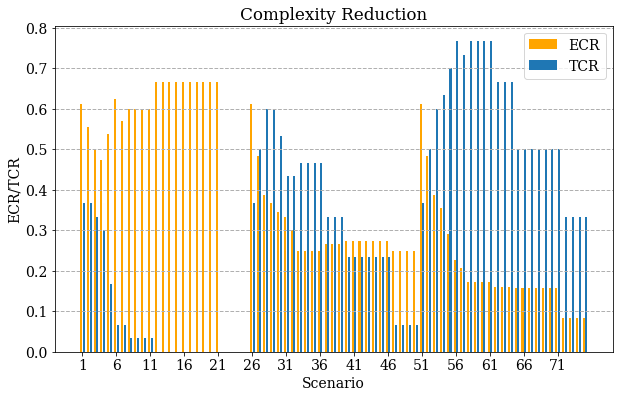

In [13]:
bar_chart(result)

Visualization of the ECR and TCR for each scenario. The best result yield the scenarios 27 & 52 with $λ = 1$, $\delta≤3$, and $|C_A|= 15$.

Below, the interdependencies of the two constraints (distance and support) for each scenario and their influence on the number of resulting high-level concepts and TCR, can be explored.

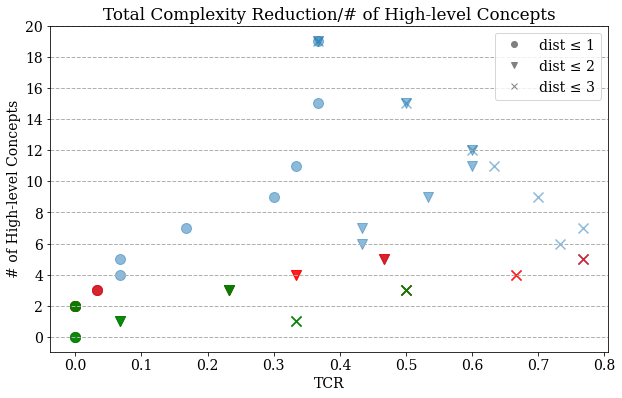

In [14]:
scatter_chart(result)

The higher the upper bound for the distance metric, the better the totalcomplexity reduction. Different colors indicate different upper-bounds forthe support: $blue \le 8$, $red \le 16$, $green > 16$.

### Process Discovery

To better illustrate the effect of the abstraction, we can discover the corresponding process models for the original/raw event log and the abstracted one. To that end, we apply the inductive miner from the [PM4Py](https://pm4py.fit.fraunhofer.de/) package.

First, we have repeat the abstraction for a selected configuration:

In [15]:
mappings_copy = deepcopy(mappings)

dist = 3 # upper bound
supp = 1 # lower bound


filtered_mappings = abs_helper.filter_abstraction_candidates(mappings_copy, dist, supp)

chosen_mappings = abs_helper.select_mapping(filtered_mappings, connector, leaf_paths)

# calculate complexity reduction metrics
ca = m_helper.get_abstraction_goals(chosen_mappings)
cla = m_helper.get_abstractable_concepts(chosen_mappings)
cl = m_helper.get_low_level_concepts(ll_concepts)
clna = m_helper.get_not_abstractable_concepts(ll_concepts, chosen_mappings)

cr = m.complexity_reduction(ca, cla)
tcr = m.complexity_reduction_total(ca, clna, cl)


# print results:

print('Abstraction insights:\n')
print('| {:^5s} | {:^5s} | {:^7s} | {:^6s} |'.format('ECR', 'TCR', '|CLA|', '|CA|'))
print('+-------+-------+---------+--------+')
print('| {:^5.3f} | {:^5.3f} | {:^7d} | {:^6d} |'.format(cr, ctr, len(cla), len(ca)))

Abstraction insights:

|  ECR  |  TCR  |  |CLA|  |  |CA|  |
+-------+-------+---------+--------+
| 0.484 | 0.333 |   30    |   15   |


Based on the abstraction result, we can enhance the original event log in the following:

In [16]:
log = xes_importer.apply(log_file)

Enhance the event log by replacing matching event labels by the corresponding high-level concept names:

In [17]:
new_log = helper.enhance_event_labels(log, event_to_con_mapping, chosen_mappings)

Discover the process model from the **original** log:

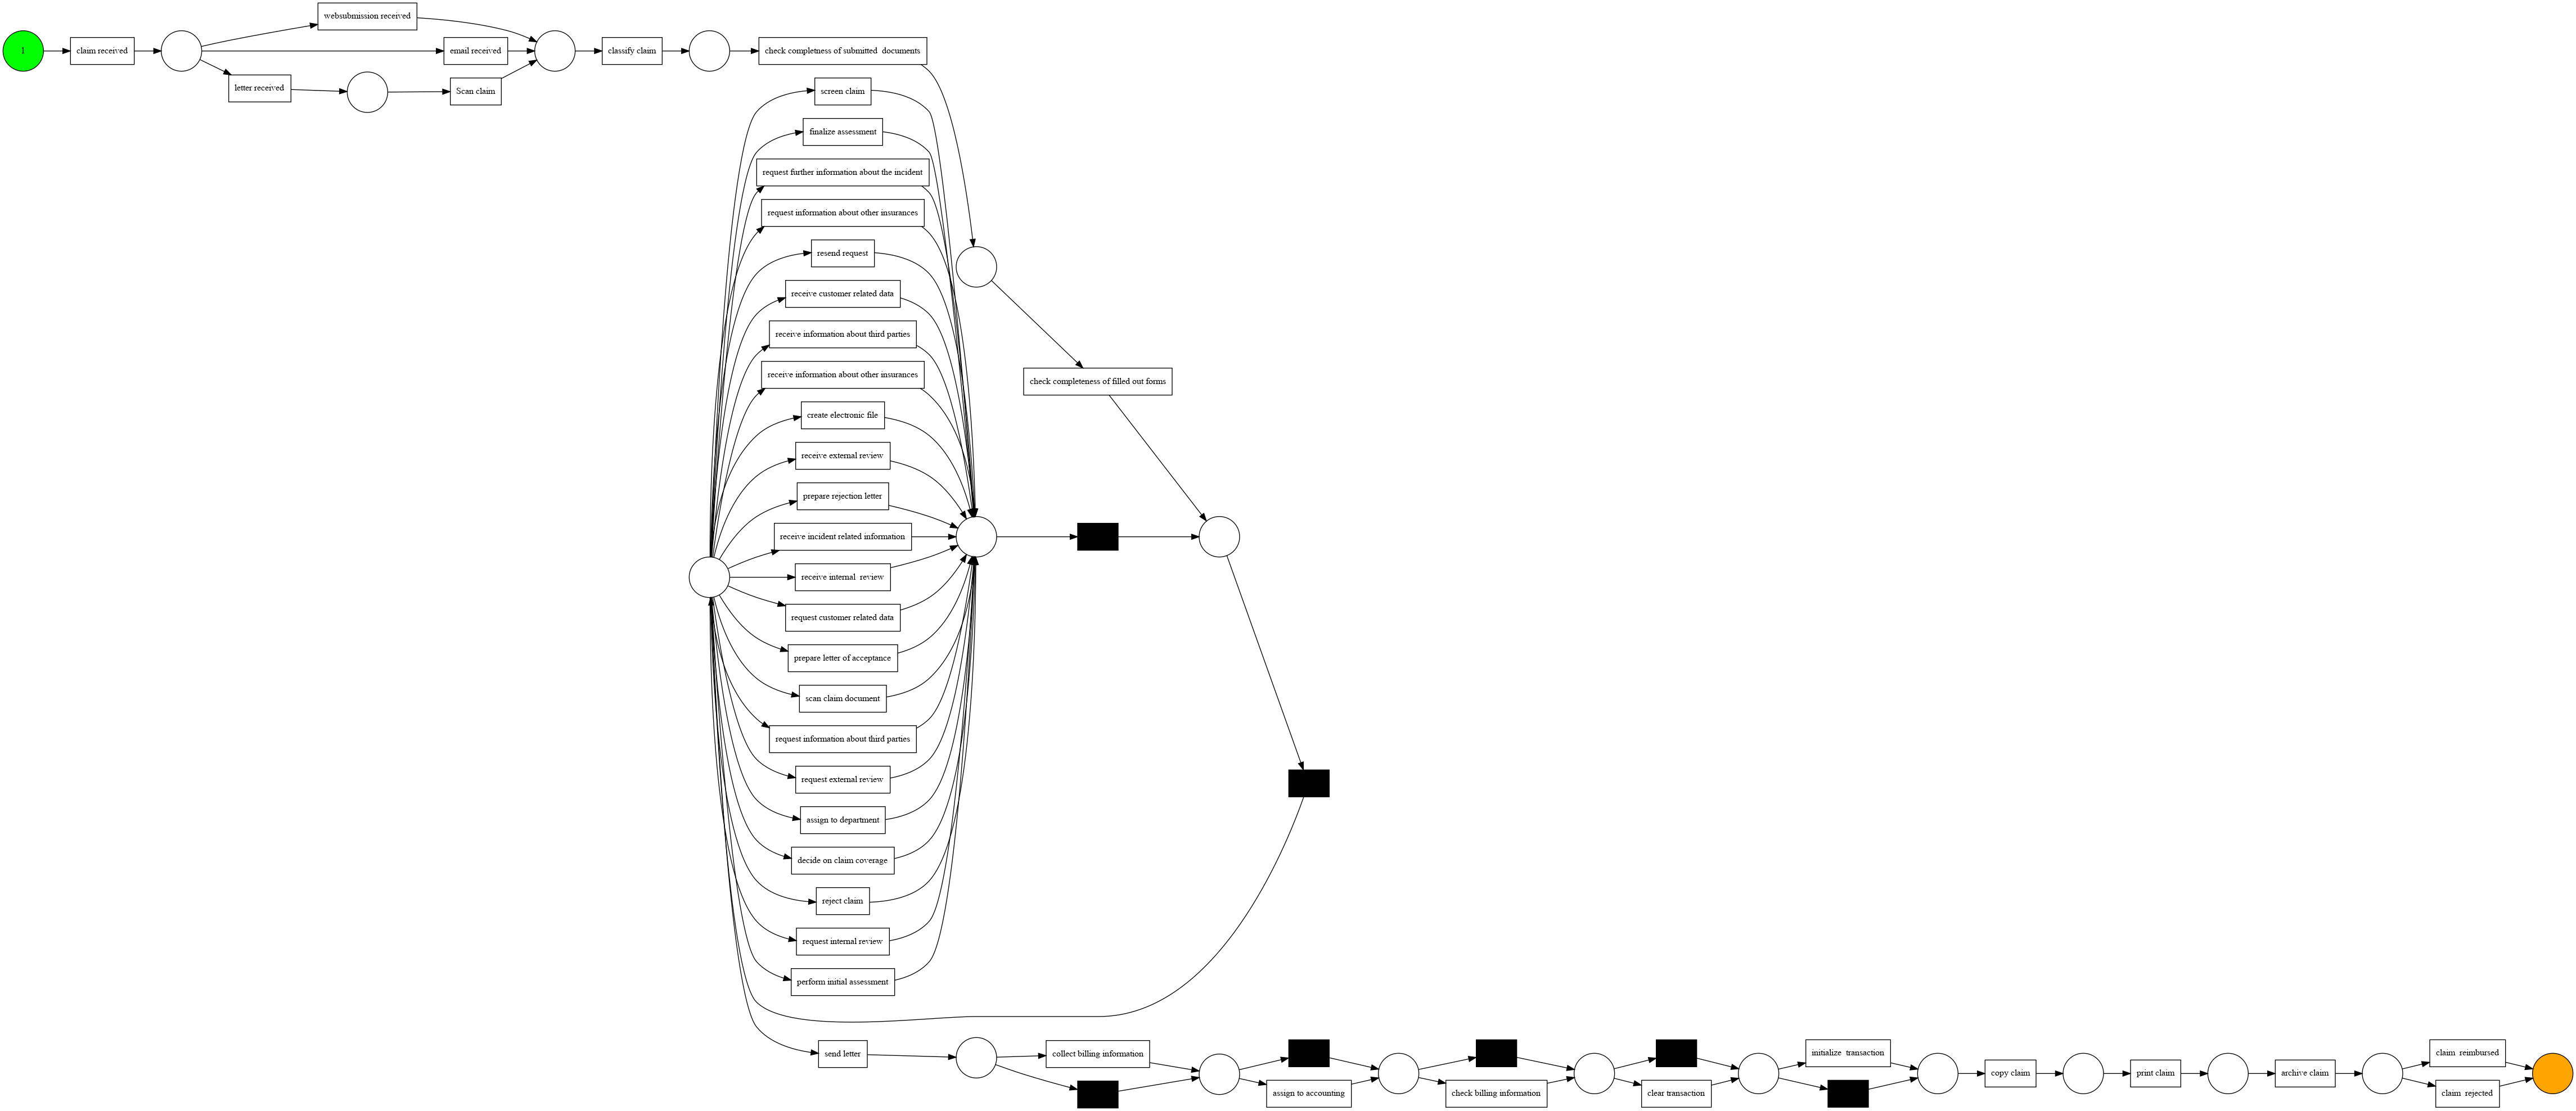

In [18]:
net, initial_marking, final_marking = inductive_miner.apply(log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

Discover the process model from the **enhanced** log:

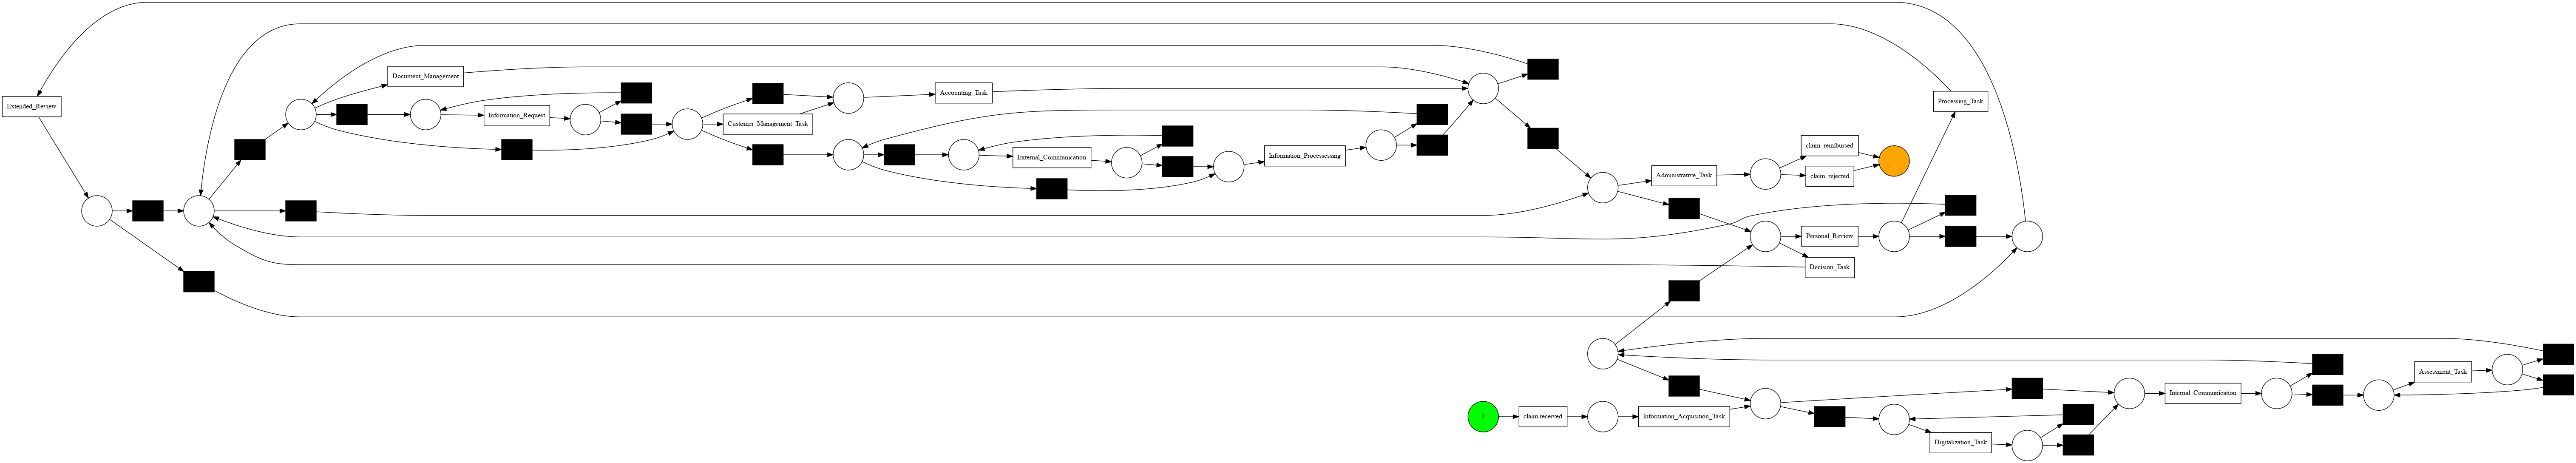

In [19]:
net, initial_marking, final_marking = inductive_miner.apply(new_log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)